<style>
.icon:hover {
  opacity: 0.7;
}
.icon { 
    overflow: hidden;
    filter: grayscale(100%);
}
</style>
<a href="https://www.linkedin.com/in/joel-montavon-704808a/" target="_blank"><img class="icon" width="60" height="60" src="https://content.linkedin.com/content/dam/me/brand/en-us/brand-home/logos/In-Blue-Logo.png.original.png" style="position: absolute; right: 80px; top: 10px;"></img></a>
<a href="https://github.com/joelmontavon/risk-adjustment" target="_blank"><img class="icon" width="80" height="80" src="https://github.githubassets.com/images/modules/logos_page/GitHub-Mark.png" style="position: absolute; right: 0px; top: 0px;"></img></a>
<h1>Risk Adjustment for Social Determinants of Health (SDOH)</h1>
<p>This tutorial will explain how to adjust healthcare quality measures for SDOH factors.</p>
<p>For this tutorial, I will use the following publicly available datasets:</p>
<ul>
    <li><b><a href="https://www.cms.gov/files/zip/2022-star-ratings-data-table-oct-06-2021.zip">2022 Star Ratings Data Table</a></b>: CMS publishes the data related to their Star Ratings on their <a href="https://www.cms.gov/Medicare/Prescription-Drug-Coverage/PrescriptionDrugCovGenIn/PerformanceData" target="_blank">Part C and D Performance Data</a> webpage.</li>
    <li><b><a href="https://www.cms.gov/files/zip/monthly-enrollment-cpsc-december-2020.zip">Monthly Enrollment by CPSC – December 2020 (ZIP)</a></b>: CMS publishes data related to enrollment in Medicare contracts on their <a href="https://www.cms.gov/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/MCRAdvPartDEnrolData/Monthly-Enrollment-by-Contract-Plan-State-County" target="_blank">Medicare Advantage/Part D Contract and Enrollment Data</a> webpage.</li>
    <li><b><a href="https://www.ahrq.gov/sites/default/files/wysiwyg/sdohchallenge/data/county_2018.XLSX">Social Determinants of Health (SDOH) Beta Data File</a></b>: The Agency for Healthcare Research and Quality (AHRQ) has published SDOH data on their <a href="https://www.ahrq.gov/sdoh/data-analytics/sdoh-data.html" target="_blank">SDOH Database</a> webpage. The data includes variables related to social context (e.g., age, race/ethnicity, veteran status), economic context (e.g., income, unemployment rate), education, physical infrastructure (e.g, housing, crime, transportation), and healthcare context (e.g., health insurance).</li>
</ul>

<p>First, I'm going to setup a variable with my path so I can read the data into dataframes.</p>

In [1]:
import os

#update with your own path; prefix your string for paths with r in windows
my_path = r'D:\projects\python\risk adj' + os.sep

<p>I read the Medicare enrollment data into a dataframe. I need to convert the column with enrollment to numbers, clean up the column names, and limit to rows with some enrollment.</p>

In [2]:
import pandas as pd
import re

def try_number(str):
    try:
        return int(str)
    except:
        return 0

#read the CSV file
enroll = pd.read_csv(my_path + 'CPSC_Enrollment_Info_2020_12.csv', converters={'Enrollment': try_number})
#rename some columns
enroll = enroll.rename(columns=lambda x: re.sub("\s+", "_", re.sub('[^A-Za-z0-9\s]+',' ', x.lower())))
#limit to rows with some enrollment
enroll = enroll[(enroll['enrollment'] != 0)]

<p>Take a look at the enrollment data after cleaning it up.</p>

In [3]:
enroll

,contract_number,plan_id,ssa_state_county_code,fips_state_county_code,state,county,enrollment
4,E0654,801,1010,1003.0,AL,Baldwin,12
72,E0654,801,2020,2020.0,AK,Anchorage,143
77,E0654,801,2090,2090.0,AK,Fairbanks North Star,87
80,E0654,801,2122,2122.0,AK,Kenai Peninsula,32
84,E0654,801,2170,2170.0,AK,Matanuska-Susitna,58
...,...,...,...,...,...,...,...
3212901,S9701,807,36480,39093.0,OH,Lorain,18
3213419,S9701,807,45550,48167.0,TX,Galveston,11
3213436,S9701,807,45610,48201.0,TX,Harris,35
3213505,S9701,807,45801,48339.0,TX,Montgomery,15


<p>I read the SDOH data into a dataframe and clean up the column names.</p>

In [4]:
#read excel file
sdoh = pd.read_excel(my_path + 'county_2018.XLSX')
#rename some columns
sdoh = sdoh.rename(columns=lambda x: re.sub("\s+", "_", re.sub('[^A-Za-z0-9\s]+',' ', x.lower())))

<p>Now, I'm going to identify the variables with at least 90% of the rows populated so I can throw them out.</p>

In [5]:
#perform a count on the variables that I care about; the first and last few rows are identifiers so not included
vars_cnts = sdoh.iloc[:, 5:224].count().reset_index()
#rename the columns
vars_cnts = vars_cnts.rename(columns={'index':'var', 0: 'n'})
#identify variables with at least 90% of the rows populated
vars = vars_cnts[vars_cnts['n'] > (vars_cnts['n'].max() * 0.9)]['var']
#convert to a list
vars = vars.values.tolist()

<p>Next, I want to eliminate any variables which are highly correlated. It is easy to create a correlation matrix in pandas using the corr() function. Pearson correlation is used by default.</p>
<p>For a subset of the variables, I have created a heatmap in the correlation matrix to give you an idea what this looks like.</p>

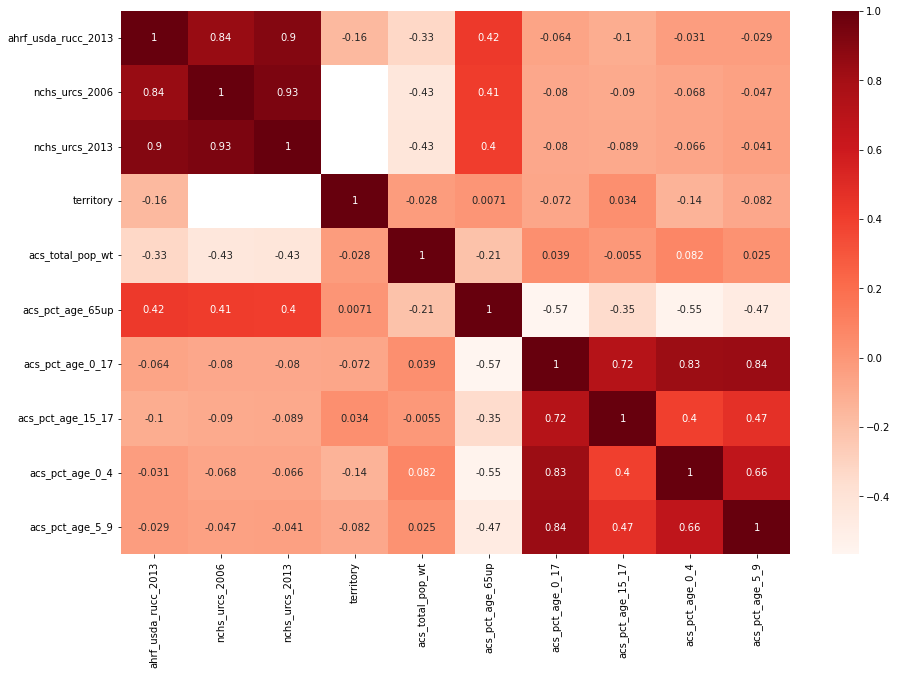

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,10))
corrMatrix = sdoh[vars[:10]].corr()
sns.heatmap(corrMatrix, annot=True, cmap=plt.cm.Reds)
plt.show()

<p>Since I have nearly 200 variables, I need to use a programatic approach to eliminating highly correlated variables.</p>

In [7]:
#calculate correlations between variables and reset index
corr = sdoh[vars].corr().reset_index()
#transform variables and their values from columns to rows
corr = pd.melt(corr, id_vars=['index'], var_name='var', value_name='val')
#rename the columns
corr = corr.rename(columns={'index':'var1', 'var':'var2', 'val': 'corr'})
#modify correlations to absolute values
corr['corr'] = corr['corr'].abs()
#no need to include correlations between a variable and itself
corr = corr[corr['var1'] != corr['var2']]

<p>Take a look with the resulting dataset with the correlations.</p>

In [8]:
corr

,var1,var2,corr
1,nchs_urcs_2006,ahrf_usda_rucc_2013,0.842705
2,nchs_urcs_2013,ahrf_usda_rucc_2013,0.903884
3,territory,ahrf_usda_rucc_2013,0.164745
4,acs_total_pop_wt,ahrf_usda_rucc_2013,0.327719
5,acs_pct_age_65up,ahrf_usda_rucc_2013,0.421954
...,...,...,...
34219,svi_rpl_theme2_hh_disb,cen_popdensity_2018,0.116198
34220,svi_rpl_theme3_mino,cen_popdensity_2018,0.154638
34221,svi_rpl_theme4_hh_trans,cen_popdensity_2018,0.097194
34222,svi_rpl_themes_all,cen_popdensity_2018,0.020505


<p>I need to identify the highly correlated variables and limit to just one of the highly correlated variables. I use the threshold of 0.7 to identify highly correlated variables.</p> 

In [9]:
#create a new dataframe with the variable and its correlations
corr_high = corr[['var1','corr']]
#set n to 0 for all rows and then update rows with correlation > 0.7 to 1
corr_high['n'] = 0
corr_high.loc[corr_high['corr'] > .7,'n'] = 1
#group by variable and count
corr_high = corr_high[['var1','n']].groupby('var1').sum().reset_index()

<p>Now, I join with the original dataset with the correlations and sort based upon the count of highly correlated variables.</p>

In [10]:
corr = pd.merge(corr, corr_high, on='var1').sort_values('n')

<p>I am almost there. I have sorted based upon the count of highly correlated variables. I now loop thru the variables keeping the first variable and throwing the other variables into a list to be excluded.</p>

In [11]:
#create list to hold the excluded variables
vars_excl = []
#loop thru the rows
for item in corr.values.tolist():
    #append var2 to list if the variables are highly correlated and neither variable is in the list of excluded variables
    if item[2] > 0.7 and not (item[0] in vars_excl) and not (item[1] in vars_excl):
        vars_excl.append(item[1])

<p>I create a final dataset from the list of variables after removing those in our list to be excluded.</p>

In [12]:
vars_incl = list(set(vars) - set(vars_excl))
sdoh = sdoh[list(sdoh.iloc[:, :5].columns) + vars_incl]

<p>Lastly, I need to deal with missing values to build the model. For missing values, I set the value to the mean for the column.</p>

In [13]:
for col in sdoh.columns[5:]:
    sdoh[col] = sdoh[col].fillna((sdoh[col].mean()))

<p>Take a look at the final SDOH dataset.</p>

In [14]:
sdoh

,state,region,county,fipscode,year,acs_pct_no_veh,acs_pct_commt_29min,svi_rpl_theme2_hh_disb,acs_pct_associate_dgr,acs_pct_nature,...,acs_pct_public_other,acs_pct_1up_rent_1room,acs_pct_grp_qrt,acs_pct_va,acs_pct_other_ins,acs_pct_commt_60minup,acs_pct_grandkid_tot,acs_pct_hh_1pers,acs_pct_nhpi,acs_pct_owner_hh_child
0,Alabama,South,Autauga County,1001,2018,5.641000,37.477000,0.581000,28.392000,0.883000,...,0.221000,1.509000,0.98900,12.283000,7.830000,5.667000,7.50200,25.115000,0.058000,34.128000
1,Alabama,South,Baldwin County,1003,2018,3.441000,34.123000,0.199000,31.312000,1.328000,...,0.469000,1.842000,1.44800,11.938000,7.566000,7.855000,9.81700,30.390000,0.004000,24.981000
2,Alabama,South,Barbour County,1005,2018,9.242000,28.231000,0.915300,25.125000,4.518000,...,1.093000,3.412000,11.24800,7.672000,7.862000,8.022000,14.77200,32.550000,0.004000,24.078000
3,Alabama,South,Bibb County,1007,2018,5.994000,23.792000,0.120300,24.373000,5.988000,...,0.415000,0.997000,9.28200,7.152000,7.763000,8.852000,21.55000,25.965000,0.000000,28.549000
4,Alabama,South,Blount County,1009,2018,4.155000,19.864000,0.318700,33.480000,2.281000,...,0.801000,1.249000,0.94200,8.532000,6.846000,17.953000,10.73700,24.709000,0.031000,30.765000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3219,Puerto Rico,NaN,Yabucoa Municipio,72151,2018,17.233000,33.662000,0.499959,26.263000,1.019000,...,0.484000,2.042000,0.21400,2.280000,1.460000,13.939000,16.28100,26.710000,0.000000,23.004000
3220,Puerto Rico,NaN,Yauco Municipio,72153,2018,15.505000,27.019000,0.499959,16.061000,5.424000,...,0.568000,1.360000,0.69400,2.814000,3.029000,4.917000,18.61100,32.743000,0.000000,19.268000
3221,US Virgin Islands,NaN,St. Croix Island,78010,2018,6.581605,29.996784,0.499959,30.506273,6.579082,...,0.741879,4.249307,3.45936,8.761711,6.352058,7.977522,8.79561,28.253058,0.092751,27.047302
3222,US Virgin Islands,NaN,St. John Island,78020,2018,6.581605,29.996784,0.499959,30.506273,6.579082,...,0.741879,4.249307,3.45936,8.761711,6.352058,7.977522,8.79561,28.253058,0.092751,27.047302


<p>I join the enrollment and SDOH data on the county codes. Then, I take the weighted average using the enrollment and SDOH variables.</p>

In [15]:
import numpy as np

#merge the enrollment and SDOH datasetws on the county code
contract_n_county_x_sdoh = pd.merge(enroll, sdoh, left_on="fips_state_county_code", right_on="fipscode", how="inner")
#group the enrollment data by contract and sum
contract_x_sdoh = enroll[['contract_number','enrollment']].groupby('contract_number').sum().reset_index()
#group by the contract
contracts=contract_n_county_x_sdoh.groupby('contract_number')

#loop over columns
for col in contract_n_county_x_sdoh.columns[12:]:
    #calculate the weigted average for column
    wt_avg = contracts.apply(lambda x: np.average(x[col], weights=x.enrollment)).reset_index()
    #rename to the original column name
    wt_avg = wt_avg.rename(columns={0:col})
    #add column to dataset grouped by contract
    contract_x_sdoh = pd.merge(contract_x_sdoh, wt_avg, how='outer', on=['contract_number'])

<p>Now, I need to read the Star Ratings data into a dataframe. I've also used a converter to remove some spaces after the contract IDs and renamed some of the columns.</p>

In [16]:
import pandas as pd
import numpy as np
import re

#update with your own path; prefix your string for paths with r in windows
file = r'D:\projects\python\risk adj\2022 Star Ratings Data Table - Measure Data (Oct 06 2021).csv'

#read the CSV file; converter strip an whitespace from contract_id
stars = pd.read_csv(file, skiprows=lambda x: x in [0,1,3], converters={'Unnamed: 0': lambda x: x.strip()})
#rename some columns
stars = stars.rename({'Unnamed: 0':'CONTRACT_ID','Unnamed: 1':'Organization Type','Unnamed: 2':'Contract Name','Unnamed: 3':'Organization Marketing Name','Unnamed: 4':'Parent Organization'}, axis='columns')
stars = stars.rename(columns=lambda x: re.sub("\s+", "_", re.sub('[^A-Za-z0-9\s]+',' ', x.lower()).strip()))

<p>I create a new column for the contract type. The contract type is determined by looking at the first character of the contract ID.</p>

In [17]:
#create column for contract type
stars['contract_type'] = stars['contract_id'].apply(lambda x: 'MAPD' if x[0] == 'H' or x[0] == 'R' else 'PDP')

<p>Next, I need to transform and clean up the data a bit. I use the melt() function to reorient the data and create a column for the measure name and rate.</p>

In [18]:
#transform columns for measure rates to rows for measure and rate
stars = pd.melt(stars, id_vars=['contract_id', 'contract_name', 'organization_marketing_name', 'organization_type', 'parent_organization', 'contract_type'], var_name='measure', value_name='rate')

<p>Then, I apply a function that attempts to convert the rates to numbers and drops contracts without a rate.</p>

In [19]:
def try_number(str):
    if '%' in str:
        return float(str.strip('%'))/100
    elif not any(c.isalpha() for c in str):
        return float(str)
    else:
        return np.nan
    
#convert rate to number
stars['rate'] = stars['rate'].apply(try_number)
#drop any rows where the contract did not receive a rate
stars = stars.dropna()
#sort by measure and rate
stars = stars.sort_values(['measure','rate'])

<p>For the purpose of this tutorial, I have limited the analysis to MAPD contracts and the Statin Use in Persons with Diabetes (SUPD) measure.</p>

In [20]:
supd = stars[(stars['measure'] == 'd12_statin_use_in_persons_with_diabetes_supd') & (stars['contract_type'] == 'MAPD')].copy(deep=True)

<p>To test for normality, I plot the data and calculate the skew. I am looking for skew between -0.5 and 0.5.</p>

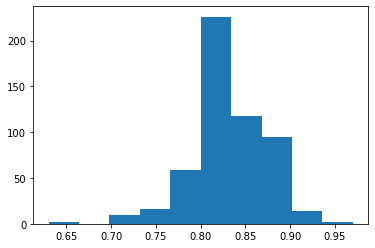

skew:  -0.3379261227466864


In [21]:
import matplotlib.pyplot as plt

plt.hist(supd['rate'])
plt.show()
print('skew: ', supd['rate'].skew())

<p>Although not terrible, I try applying several different function to tranform the data and see if I can make it more normally distributed.</p>
<p><i>Note: Although I didn't do it for this tutorial, you may consider transforming the independent variables to make them more normally distributed as well.</i></p>

sqrt -0.4755412922079663


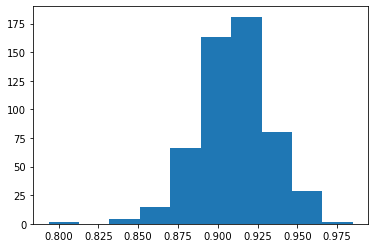

log -0.6225758106286644


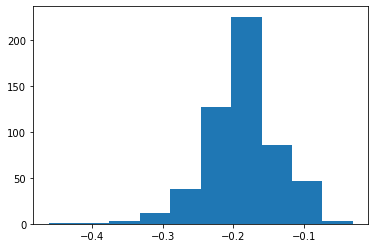

norm -0.33792612274668726


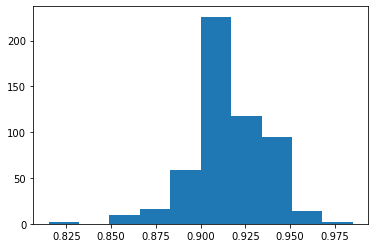

lognorm -0.45963523291746566


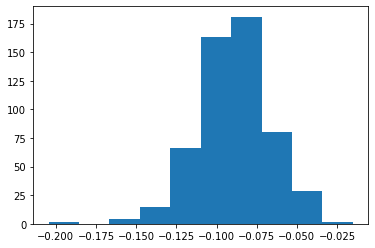

boxcox 0    0.045419
dtype: float64


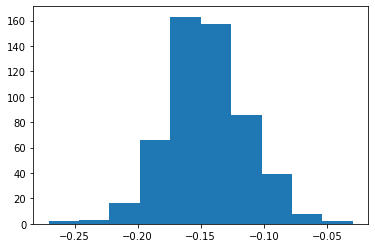

In [22]:
import matplotlib.pyplot as plt
import scipy.stats as stats

def norm(col):
    return (1+col)/2

def lognorm(col):
    return np.log(norm(col))

def boxcox(col):
     return pd.DataFrame(stats.boxcox(col)[0])

for fun in [np.sqrt, np.log, norm, lognorm, boxcox]:
    rate_norm = fun(supd['rate'])
    print(fun.__name__, rate_norm.skew())
    plt.hist(rate_norm)
    plt.show()

<p>The Box-Cox power transformation is best so will use that in my model.<p>

In [23]:
supd['rate_norm'], lmbda = stats.boxcox(supd['rate'])

<p>My data is ready to go so join the SDOH and SUPD datasets to create our training dataset. I fill any missing values with 0.</p>

In [24]:
training = pd.merge(contract_x_sdoh, supd, left_on=['contract_number'], right_on=['contract_id'], how='inner').drop(columns = ['contract_name','organization_marketing_name','organization_type'])
training = training.fillna(0)

<p>I need to identify the optimal number of features for training my linear regression model so run sequential feature selection for an increasing number of features up to 20.</p>
<p>Forward selection is used by default. And, I use the R<sup>2</sup> to score the models.</p>

In [25]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn import linear_model

x = training.iloc[:, 2:-6]
y = training['rate_norm']

features = pd.DataFrame({'n':[], 'r2':[]})
for i in range(1, 21, 1):
    regr = linear_model.LinearRegression()
    sfs = SequentialFeatureSelector(regr, n_features_to_select=i, scoring='r2')
    x_selected = sfs.fit_transform(x, y)
    regr.fit(x_selected, y)
    features = features.append({'n': i, 'r2': regr.score(x_selected, y)}, ignore_index=True)

<p>The graph shows that 7 features is the sweet spot for minimizing the features and maximizing the R<sup>2</sup>.</p>

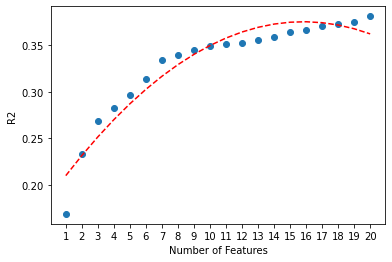

In [26]:
import matplotlib.pyplot as plt

plt.scatter(features['n'], features['r2'])
z = np.polyfit(features['n'], features['r2'], 2)
p = np.poly1d(z)
plt.xlabel("Number of Features")
plt.ylabel("R2")
plt.xticks(features['n'])
plt.plot(features['n'], p(features['n']), "r--")
plt.show()

<p>I rerun sequential feature section using 7 features and reduce to the features selected.</p>

In [27]:
regr = linear_model.LinearRegression()
sfs = SequentialFeatureSelector(regr, n_features_to_select=7, scoring='r2')
x_selected = sfs.fit_transform(x, y)

<p>The table below shows the features selected for the model and some additional information from the <a href="https://www.ahrq.gov/sites/default/files/wysiwyg/sdohchallenge/data/sdoh_codebook_final.xlsx">Variable Codebook</a>.</p>
<table>
    <tr><th>Topic</th><th>Variable_Name</th><th>Variable_Label</th></tr>
    <tr><td>Demographics</td><td>ACS_PCT_NONCTN_2010</td><td>Percentage of population who are not U.S. citizens and entered U.S. since 2010</td></tr>
    <tr><td>Living Conditions</td><td>ACS_PCT_DIVORCE_SEPARAT</td><td>Percentage of population divorced or separated (ages 15 and over)</td></tr>
    <tr><td>Workforce / Employment</td><td>ACS_PCT_VA_LABOR_FORCE</td><td>Percentage of civilian veterans in labor force (ages 18–64)</td></tr>
    <tr><td>Income</td><td>ACS_PCT_1FAM_HH_FOOD_STMP</td><td>Percentage of unmarried partner households that received food stamps/Supplemental Nutrition Assistance Program (SNAP) benefits</td></tr>
    <tr><td>Transportation</td><td>ACS_PCT_COMMT_15MIN</td><td>Percentage of workers with < 15-minute commute time (ages 16 and over)</td></tr>
    <tr><td>Access</td><td>AHRF_HPSA_PRIM</td><td>HPSA code—shortage of primary care physicians</td></tr>
    <tr><td>Access</td><td>MP_PERCPEN</td><td>Derived field that equals the ratio of enrollees over eligibles * 100</td></tr>
</table>

In [28]:
list(x.iloc[:, sfs.get_support()].columns)

['acs_pct_divorce_separat',
 'mp_percpen',
 'ahrf_hpsa_prim',
 'acs_pct_commt_15min',
 'acs_pct_nonctn_2010',
 'acs_pct_1fam_hh_food_stmp',
 'acs_pct_va']

<p>I fit the regression model to the selected features, predict the values using the model, and then reverse the Box-Cox transformation.</p>

In [29]:
import scipy.special as sp

#fit the model
regr.fit(x_selected, y)
#predict the scores with the model
rate_pred = regr.predict(x_selected)
#reverse the Box-Cox transformation
training['rate_pred'] = sp.inv_boxcox(rate_pred, lmbda)

<p>I calculate the average rate using a weighted average.</p>

In [30]:
training

,contract_number,enrollment,acs_pct_no_veh,acs_pct_commt_29min,svi_rpl_theme2_hh_disb,acs_pct_associate_dgr,acs_pct_nature,acs_pct_age_15_17,acs_pct_educ,acs_pct_api_lang,...,acs_pct_hh_1pers,acs_pct_nhpi,acs_pct_owner_hh_child,contract_id,parent_organization,contract_type,measure,rate,rate_norm,rate_pred
0,H0028,340598,5.910785,38.106586,0.397531,31.024918,1.887378,4.076312,22.044589,2.682903,...,26.809484,0.344132,32.112275,H0028,Humana Inc.,MAPD,d12_statin_use_in_persons_with_diabetes_supd,0.84,-0.140597,0.825054
1,H0062,2944,6.717585,44.098061,0.643300,24.796469,2.575842,5.070264,28.075170,1.394048,...,19.914386,0.046782,42.370965,H0062,Centene Corporation,MAPD,d12_statin_use_in_persons_with_diabetes_supd,0.88,-0.108998,0.857331
2,H0104,89089,6.040407,37.577188,0.525280,29.925608,1.726311,3.974771,22.077368,0.770110,...,29.279129,0.042495,27.881597,H0104,BlueCross BlueShield of Alabama,MAPD,d12_statin_use_in_persons_with_diabetes_supd,0.80,-0.169927,0.822678
3,H0107,14881,4.784203,39.043616,0.231744,32.145580,4.168727,3.522629,23.572003,0.601140,...,29.912976,0.076981,27.113348,H0107,Health Care Service Corporation,MAPD,d12_statin_use_in_persons_with_diabetes_supd,0.79,-0.176913,0.770099
4,H0111,4981,6.475404,36.923689,0.448879,30.306813,0.535472,4.114682,21.363434,2.152922,...,26.753538,0.096129,31.332355,H0111,Centene Corporation,MAPD,d12_statin_use_in_persons_with_diabetes_supd,0.78,-0.183762,0.831297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536,R6694,3472,8.732237,35.571884,0.284978,26.245304,0.675984,3.920213,24.903090,2.995190,...,27.255474,0.035516,29.839224,R6694,CVS Health Corporation,MAPD,d12_statin_use_in_persons_with_diabetes_supd,0.78,-0.183762,0.829360
537,R6801,129167,5.515881,32.343138,0.543090,29.734515,6.119373,4.240718,22.580369,1.699430,...,25.472338,0.085476,33.351501,R6801,"UnitedHealth Group, Inc.",MAPD,d12_statin_use_in_persons_with_diabetes_supd,0.80,-0.169927,0.822124
538,R7220,6717,6.385262,33.184329,0.660835,36.311455,4.194965,3.838803,23.886536,1.167543,...,27.588423,0.163693,24.890644,R7220,Humana Inc.,MAPD,d12_statin_use_in_persons_with_diabetes_supd,0.74,-0.209807,0.798320
539,R7315,14504,6.104441,36.356507,0.587321,28.498690,2.015398,3.922455,21.921160,0.669675,...,28.813055,0.059881,27.135568,R7315,Humana Inc.,MAPD,d12_statin_use_in_persons_with_diabetes_supd,0.83,-0.148140,0.817240


In [31]:
#calculate the weighted average
rate_avg = training.groupby(['measure']).apply(lambda x: np.average(x['rate'], weights=x.enrollment)).reset_index()
#rename the column
rate_avg = rate_avg.rename(columns={0:'rate_avg'})

<p>I calculate the adjusted rate by dividing the actual rate by the predicated rate and multiplying by the average rate. I round to 2 decimal places and calculate the difference between the actual and adjusted rates.</p>

In [32]:
result = pd.merge(training, rate_avg, how='inner', on=['measure'])
result['rate_adj'] = result['rate'] / result['rate_pred'] * result['rate_avg']
result['rate_adj'] = result['rate_adj'].round(2)
result['rate_diff'] = result['rate_adj'] - result['rate']

<p>I plot the difference between the actual and adjusted rates. Rates changed by as much as -6 to 8%!</p>

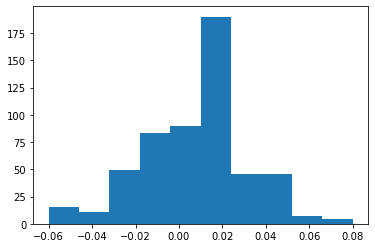

In [33]:
plt.hist(result['rate_diff'])
plt.show()

<script>
window.addEventListener('load', function() {
	let message = { height: document.body.scrollHeight, width: document.body.scrollWidth };	

	// window.top refers to parent window
	window.top.postMessage(message, "*");
});
</script>